<a href="https://colab.research.google.com/github/Samarth-991/Pose-Estimation/blob/main/Pose_Estiamation_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd 
import os 
import tqdm
from matplotlib import pyplot as plt 
import cv2 
from google.colab.patches import cv2_imshow
import urllib.request

# Download the video
url_link = 'https://drive.google.com/file/d/1kFWHaAaeRU4biZ_1wKZlL4KCd0HSoNYd/view?usp=sharing'
# urllib.request.urlretrieve(url_link, 'video_sample.mp4') 
video_path = '/content/video_sample.mp4'

## MediaPipe 

Mediapipe is a framework mainly used for building multimodal audio, video, or any time series data. With the help of the MediaPipe framework, an impressive ML pipeline can be built for instance of inference models like TensorFlow, TFLite, and also for media processing functions.

## Models using Mediapipe
* Face Detection
* Multi-hand Tracking
* Hair Segmentation
* Object Detection and Tracking
* Objectron: 3D Object Detection and Tracking
* AutoFlip: Automatic video cropping pipeline
* Pose Estimation

Source : https://google.github.io/mediapipe/solutions/pose.html

![Picture](https://google.github.io/mediapipe/images/mobile/pose_tracking_full_body_landmarks.png)

In [ ]:
# ! pip install mediapipe 
import mediapipe as mp
import time

mpPose = mp.solutions.pose
pose = mpPose.Pose()
mpdraw = mp.solutions.drawing_utils

In [27]:
# Open the video.
video_cap = cv2.VideoCapture(video_path)

# Get some video parameters to generate output video with classificaiton.
video_n_frames = video_cap.get(cv2.CAP_PROP_FRAME_COUNT)
video_fps = video_cap.get(cv2.CAP_PROP_FPS)
video_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print("Video Frames: {}".format(video_n_frames))
print("video FPS: {}".format(video_fps))
print("Shape: {}x{}".format(video_width,video_height))
print("video length {} seconds".format(video_n_frames//video_fps))

Video Frames: 299.0
video FPS: 30.0
Shape: 640x360
video length 9.0 seconds


In [28]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open(video_path,'rb').read()
decoded_vid = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'<video width=400 controls><source src={decoded_vid} type="video/mp4"></video>')

In [29]:
# Open output video.
out_video_path = '/content/output_video_sample.mp4'
out_video = cv2.VideoWriter(out_video_path, cv2.VideoWriter_fourcc(*'MP4V'), video_fps, (video_width, video_height))
overlay = False
saved_landmarks = list()

with tqdm.tqdm(total=video_n_frames, position=0, leave=True) as pbar:
    while True:
        success,input_frame = video_cap.read()
        if not success:
            break 
        # run Pose detection/tracker
        input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
        #input_frame.flags.writable = False

        results = pose.process(image=input_frame)
        input_frame.flags.writeable = True
        pose_landmarks = results.pose_landmarks
        # print(results.pose_landmarks)
        if pose_landmarks is not None:
            mpdraw.draw_landmarks(image=input_frame,
                                  landmark_list=pose_landmarks,
                                  connections=mpPose.POSE_CONNECTIONS)
            output_frame = input_frame.copy()
            if overlay:
                for id, lm in enumerate(pose_landmarks.landmark): 
                    cx ,cy = int(lm.x*video_width),int(lm.y*video_height)
                    output_frame = cv2.circle(output_frame, (cx, cy), 3, (255,255,0), cv2.FILLED)
            # Check the number of landmarks and take pose landmarks.
            assert len(pose_landmarks.landmark) == 33, 'Unexpected number of predicted pose landmarks: {}'.format(len(pose_landmarks.landmark))
            frame_height, frame_width = output_frame.shape[:2]
            pose_landmarks_list =np.array ([[int(frame_width*lmk.x), int(lmk.y*frame_height), int(frame_width*lmk.z)] for lmk in pose_landmarks.landmark])
            saved_landmarks.append(pose_landmarks_list) 
            # Save the output frame.
            out_video.write(cv2.cvtColor(np.array(output_frame), cv2.COLOR_RGB2BGR))
    video_cap.release()
    out_video.release()
    cv2.destroyAllWindows()

  0%|          | 0/299.0 [00:20<?, ?it/s]


In [30]:
saved_landmarks = np.asarray(saved_landmarks)
saved_landmarks.shape

(299, 33, 3)

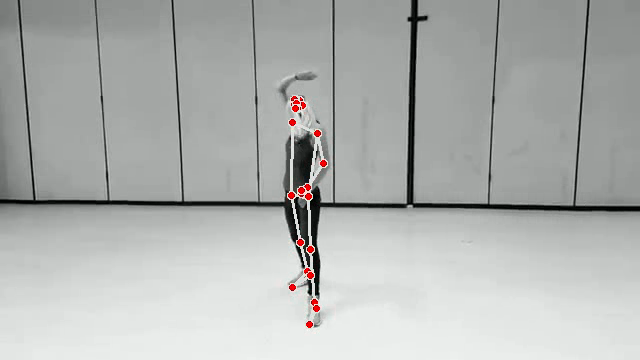

In [31]:
## show a random frame
out_cap = cv2.VideoCapture(out_video_path)
out_cap.set(cv2.CAP_PROP_POS_MSEC,np.random.randint(1500,9000)) # cue to any random second 
while True:
    success,input_frame = out_cap.read()
    if not success:
        break
    input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
    cv2_imshow(input_frame)
    break

In [32]:
df = pd.DataFrame(saved_landmarks.reshape(-1, 3), columns=list('XYZ'))
df.index = np.repeat(np.arange(saved_landmarks.shape[0]), saved_landmarks.shape[1]) + 1
df.index.name = 'Frame'
df.tail()

,X,Y,Z
Frame,,,
299,278,255,40
299,373,278,78
299,282,264,44
299,379,288,21
299,255,266,-10


## Hand Position Estimation 
To detect initial hand locations, we designed a single-shot detector model optimized for mobile real-time uses in a manner similar to the face detection model in MediaPipe Face Mesh. Detecting hands is a decidedly complex task: our lite model and full model have to work across a variety of hand sizes with a large scale span (~20x) relative to the image frame and be able to detect occluded and self-occluded hands. 

![picture](https://media.geeksforgeeks.org/wp-content/uploads/20210802154942/HandLandmarks.png)

In [10]:
#! pip install mediapipe 
import numpy as np
import pandas as pd 
import os 
import tqdm
from matplotlib import pyplot as plt 
import cv2 
from google.colab.patches import cv2_imshow
import mediapipe as mp
import time

mphands = mp.solutions.hands # hands model 
mpdraw = mp.solutions.drawing_utils


In [11]:
from IPython.display import HTML
from base64 import b64encode
hand_video = '/content/handpose.mp4'
see_video = False

if see_video:
    mp4 = open(hand_video,'rb').read()
    decoded_vid = "data:video/mp4;base64," + b64encode(mp4).decode()
    HTML(f'<video width=400 controls><source src={decoded_vid} type="video/mp4"></video>')

In [12]:
# Open the video.
video_cap = cv2.VideoCapture(hand_video)

# Get some video parameters to generate output video with classificaiton.
video_n_frames = video_cap.get(cv2.CAP_PROP_FRAME_COUNT)
video_fps = video_cap.get(cv2.CAP_PROP_FPS)
video_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print("Video Frames: {}".format(video_n_frames))
print("video FPS: {}".format(video_fps))
print("Shape: {}x{}".format(video_width,video_height))
print("video length {} seconds".format(video_n_frames//video_fps))

Video Frames: 986.0
video FPS: 29.98643615565373
Shape: 640x480
video length 32.0 seconds


In [13]:
out_video_path = '/content/output_hand_sample.mp4'
out_video = cv2.VideoWriter(out_video_path, cv2.VideoWriter_fourcc(*'MP4V'), video_fps, (video_width, video_height))
overlay = False
save_landmarks = True
with mphands.Hands(min_detection_confidence=0.8,min_tracking_confidence=0.5) as hands:
    while True:
        success,input_frame = video_cap.read()
        if not success:
            break 
        # run Pose detection/tracker
        input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
        # input_frame.flags.writable = False
        results = hands.process(image=input_frame)
        # input_frame.flags.writeable = True
        hand_landmarks = results.multi_hand_landmarks
        # make a copy of input frame
        output_frame = input_frame.copy()
        
        if hand_landmarks is not None:
            for num, hand in enumerate(hand_landmarks):
                mpdraw.draw_landmarks(output_frame,
                                      hand,
                                      mphands.HAND_CONNECTIONS)
        # Save the output frame.
        out_video.write(cv2.cvtColor(np.array(output_frame), cv2.COLOR_BGR2RGB))

    video_cap.release()
    out_video.release()
    cv2.destroyAllWindows()        

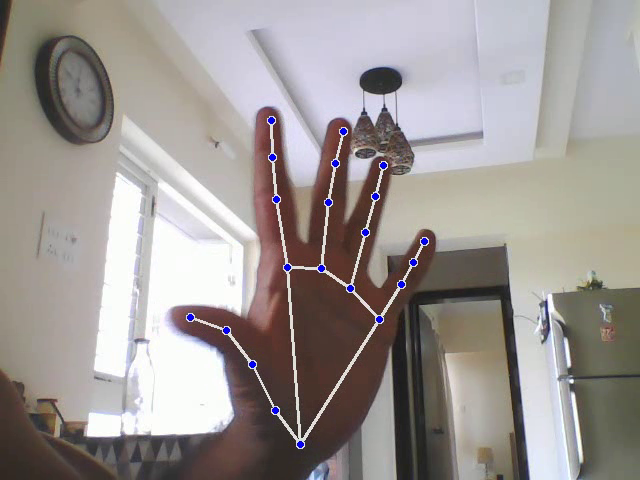

In [8]:
## show a random frame
out_cap = cv2.VideoCapture(out_video_path)
out_cap.set(cv2.CAP_PROP_POS_MSEC,np.random.randint(1500,15000)) # cue to any random second 
while True:
    success,input_frame = out_cap.read()
    if not success:
        break
    cv2_imshow(input_frame)
    break